<a href="https://colab.research.google.com/github/catoverhat/Predictive-Analytics-for-Business/blob/main/Linear%20regression/Predicting_Catalog_Demand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# The Business Problem

You recently started working for a company that manufactures and sells high-end home goods. Last year the company sent out its first print catalog, and is preparing to send out this year's catalog in the coming months. The company has 250 new customers from their mailing list that they want to send the catalog to.

Your manager has been asked to determine how much profit the company can expect from sending a catalog to these customers. You, the business analyst, are assigned to help your manager run the numbers. While fairly knowledgeable about data analysis, your manager is not very familiar with predictive models.

You’ve been asked to predict the expected profit from these 250 new customers. Management does not want to send the catalog out to these new customers unless the expected profit contribution exceeds \$10,000.

Details 
*   The costs of printing and distributing is \$6.50 per catalog.
*   The average gross margin (price - cost) on all products sold through the catalog is 50%.
*   Make sure to multiply your revenue by the gross margin first before you subtract out the \$6.50 cost when calculating your profit.







In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [2]:
df_customer = pd.read_excel("p1-customers.xlsx")
df_mailinglist = pd.read_excel("p1-mailinglist.xlsx")

In [4]:
df_customer.head()

,Name,Customer_Segment,Customer_ID,Address,City,State,ZIP,Avg_Sale_Amount,Store_Number,Responded_to_Last_Catalog,Avg_Num_Products_Purchased,#_Years_as_Customer
0,Pamela Wright,Store Mailing List,2,376 S Jasmine St,Denver,CO,80224,227.90,100,No,1,6
1,Danell Valdez,Store Mailing List,7,12066 E Lake Cir,Greenwood Village,CO,80111,55.00,105,Yes,1,6
2,Jessica Rinehart,Store Mailing List,8,7225 S Gaylord St,Centennial,CO,80122,212.57,101,No,1,3
3,Nancy Clark,Store Mailing List,9,4497 Cornish Way,Denver,CO,80239,195.31,105,Yes,1,6
4,Andrea Brun,Store Mailing List,10,2316 E 5th Ave,Denver,CO,80206,110.55,100,Yes,1,2


In [89]:
df_customer.dtypes

Name                           object
Customer_Segment               object
Customer_ID                     int64
Address                        object
City                           object
State                          object
ZIP                             int64
Avg_Sale_Amount               float64
Store_Number                    int64
Responded_to_Last_Catalog      object
Avg_Num_Products_Purchased      int64
#_Years_as_Customer             int64
dtype: object

In [5]:
df_mailinglist.head()

,Name,Customer_Segment,Customer_ID,Address,City,State,ZIP,Store_Number,Avg_Num_Products_Purchased,#_Years_as_Customer,Score_No,Score_Yes
0,A Giametti,Loyalty Club Only,2213,5326 S Lisbon Way,Centennial,CO,80015,105,3,0.2,0.694964,0.305036
1,Abby Pierson,Loyalty Club and Credit Card,2785,4344 W Roanoke Pl,Denver,CO,80236,101,6,0.6,0.527275,0.472725
2,Adele Hallman,Loyalty Club Only,2931,5219 S Delaware St,Englewood,CO,80110,101,7,0.9,0.421118,0.578882
3,Alejandra Baird,Loyalty Club Only,2231,2301 Lawrence St,Denver,CO,80205,103,2,0.6,0.694862,0.305138
4,Alice Dewitt,Loyalty Club Only,2530,5549 S Hannibal Way,Centennial,CO,80015,104,4,0.5,0.612294,0.387706


In [88]:
df_mailinglist.dtypes

Name                           object
Customer_Segment               object
Customer_ID                     int64
Address                        object
City                           object
State                          object
ZIP                             int64
Store_Number                    int64
Avg_Num_Products_Purchased      int64
#_Years_as_Customer           float64
Score_No                      float64
Score_Yes                     float64
dtype: object

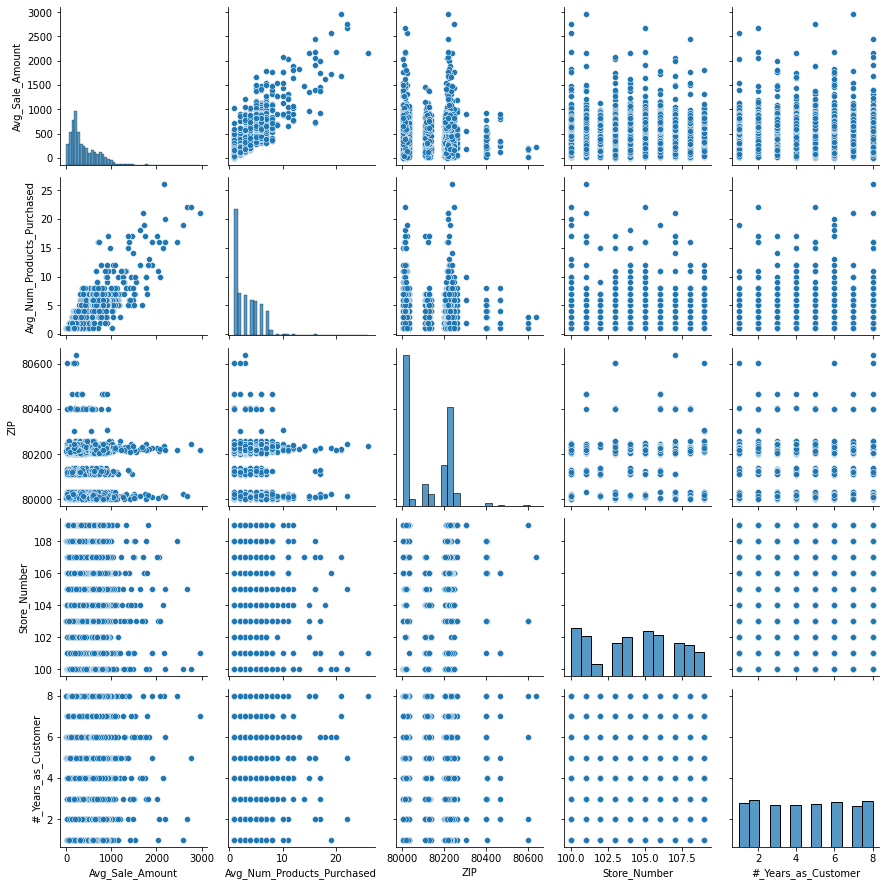

In [60]:
sns.pairplot(df_customer[['Avg_Sale_Amount', 'Avg_Num_Products_Purchased', 'ZIP', 'Store_Number', '#_Years_as_Customer']])

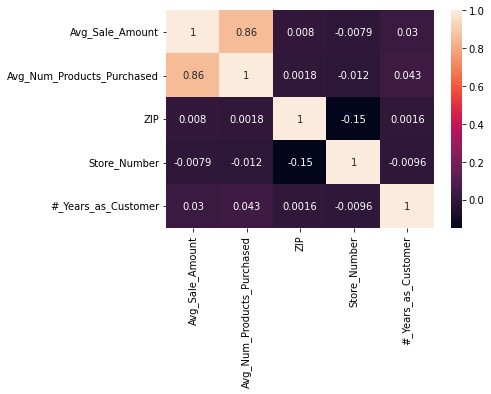

In [63]:
sns.heatmap(df_customer[['Avg_Sale_Amount', 'Avg_Num_Products_Purchased', 'ZIP', 'Store_Number', '#_Years_as_Customer']].corr(), annot=True)
#df_customer

In [40]:
df = df_customer.groupby(['ZIP'])['ZIP'].count().reset_index(name='count')
df.sort_values(by='count', ascending=False)

,ZIP,count
8,80013,127
54,80219,93
10,80015,90
7,80012,88
14,80020,87
...,...,...
23,80108,2
79,80303,2
32,80124,2
80,80305,1


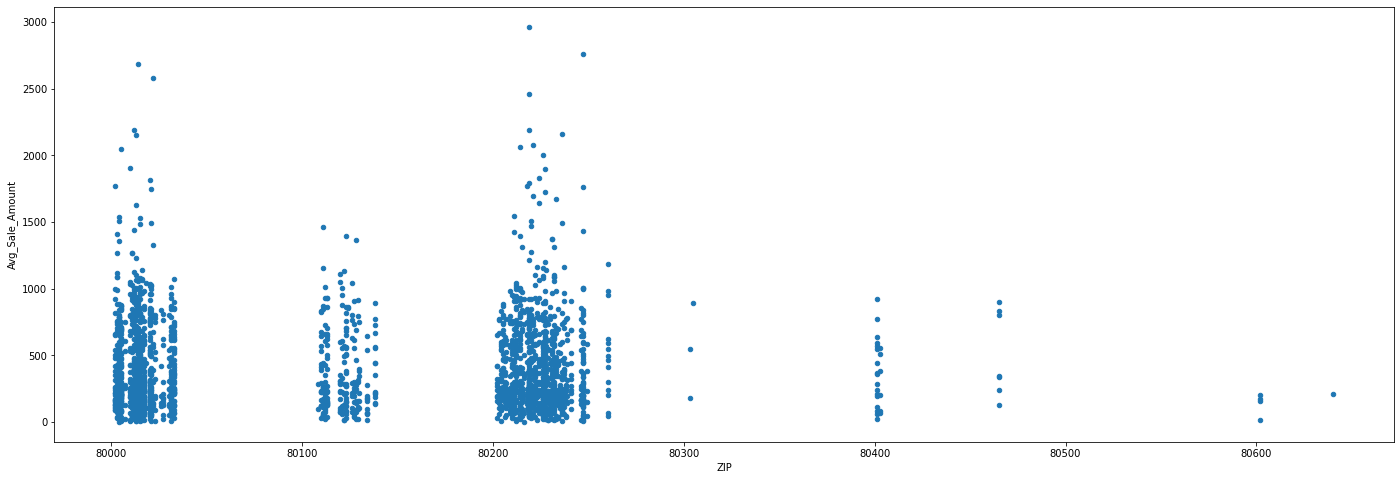

In [37]:
df_customer.plot(kind='scatter', x='ZIP', y='Avg_Sale_Amount', figsize=(24, 8))

In [13]:
df_customer['Customer_Segment'].unique()

array(['Store Mailing List', 'Loyalty Club and Credit Card',
       'Loyalty Club Only', 'Credit Card Only'], dtype=object)

In [44]:
cus_seg_dum = pd.get_dummies(df_customer['Customer_Segment'], prefix='cus_seg').iloc[:, 1:]
new_cus_seg_dum = pd.get_dummies(df_mailinglist['Customer_Segment'], prefix='cus_seg').iloc[:, 1:]

In [67]:
df = pd.concat([df_customer, cus_seg_dum], axis=1, join='inner')
new_df = pd.concat([df_mailinglist, new_cus_seg_dum], axis=1, join='inner')
new_df1 = new_df[['Avg_Num_Products_Purchased', 'cus_seg_Loyalty Club Only', 'cus_seg_Loyalty Club and Credit Card',
       'cus_seg_Store Mailing List']]
df.columns

Index(['Name', 'Customer_Segment', 'Customer_ID', 'Address', 'City', 'State',
       'ZIP', 'Avg_Sale_Amount', 'Store_Number', 'Responded_to_Last_Catalog',
       'Avg_Num_Products_Purchased', '#_Years_as_Customer',
       'cus_seg_Loyalty Club Only', 'cus_seg_Loyalty Club and Credit Card',
       'cus_seg_Store Mailing List'],
      dtype='object')

In [49]:
X = df[['Avg_Num_Products_Purchased', 'cus_seg_Loyalty Club Only', 'cus_seg_Loyalty Club and Credit Card',
       'cus_seg_Store Mailing List']]
y = df['Avg_Sale_Amount']
lm = sm.OLS(y, sm.add_constant(X))
results = lm.fit()
results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Avg_Sale_Amount   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     3040.
Date:                Fri, 24 Jun 2022   Prob (F-statistic):               0.00
Time:                        00:36:17   Log-Likelihood:                -15061.
No. Observations:                2375   AIC:                         3.013e+04
Df Residuals:                    2370   BIC:                         3.016e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                  303.4635     10.576     28.694      0.000     282.725     324.202
Avg_Num_Products_Purchased              66.9762      1.515     44.208      0.000      64.005      69.947
cus_seg_Loyalty Club Only             -149.3557      8.973    -16.645      0.000    -166.951    -131.760
cus_seg_Loyalty Club and Credit Card   281.8388     11.910     23.664      0.000     258.484     305.194
cus_seg_Store Mailing List            -245.4177      9.768    -25.125      0.000    -264.572    -226.263
==============================================================================
Omnibus:                      359.638   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4770.580
Skew:                           0.232   Prob(JB):                         0.00
Kurtosis:                       9.928   Cond. No.                         25.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
results.pvalues

const                                   1.122713e-155
Avg_Num_Products_Purchased              7.989877e-312
cus_seg_Loyalty Club Only                6.345836e-59
cus_seg_Loyalty Club and Credit Card    2.580355e-111
cus_seg_Store Mailing List              1.050298e-123
dtype: float64

In [51]:
model = LinearRegression().fit(X, y)
model.score(X,y), model.intercept_

(0.8368777093556734, 303.46347131467303)

In [55]:
pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])

,Coefficient
Avg_Num_Products_Purchased,66.976205
cus_seg_Loyalty Club Only,-149.355722
cus_seg_Loyalty Club and Credit Card,281.838765
cus_seg_Store Mailing List,-245.417744


In [73]:
predictions = model.predict(new_df1)

In [104]:
spend_by_customer = pd.DataFrame(predictions, columns=['Spend_by_customer'])
conclusion = pd.concat([spend_by_customer, df_mailinglist['Score_Yes']],axis=1, join='inner')
conclusion['revenue'] = conclusion['Spend_by_customer'] * conclusion['Score_Yes']

In [108]:
sum(conclusion['revenue'] * .5 - 6.5)

21987.435686545316

Fulfils the request of 10,000 in profits 